<a href="https://colab.research.google.com/github/comparativechrono/Rephasing-of-Seasonal-Birth-Rates-in-the-United-Kingdom-/blob/main/Figures/FIGURE_3_REVISED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Figure 2 - panel A

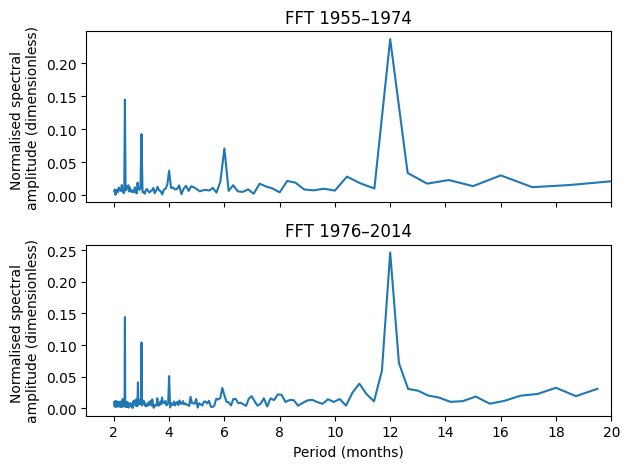

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1. Load and tidy the data
# ------------------------------------------------------------------
data = pd.read_csv("data.csv", names=["Year", "Month", "Births", "PeakConceptionMonth"])

# Title-case month names so that pd.to_datetime parses them reliably
data["Month"] = data["Month"].str.capitalize()

# Combine Year + Month into a proper datetime index (optional but handy)
data["Date"] = pd.to_datetime(data["Year"].astype(str) + " " + data["Month"], format="%Y %B")

# ------------------------------------------------------------------
# 2. Split the data into the two eras of interest
# ------------------------------------------------------------------
era1 = data[(data["Year"] >= 1955) & (data["Year"] <= 1974)].reset_index(drop=True)
era2 = data[(data["Year"] >= 1976) & (data["Year"] <= 2014)].reset_index(drop=True)

# ------------------------------------------------------------------
# 3. Z-score births within each era
#    (dimensionless series with mean 0 and SD 1)
# ------------------------------------------------------------------
era1_z = (era1["Births"] - era1["Births"].mean()) / era1["Births"].std(ddof=0)
era2_z = (era2["Births"] - era2["Births"].mean()) / era2["Births"].std(ddof=0)

# ------------------------------------------------------------------
# 4. FFT and spectral amplitude (normalised by N for comparability)
# ------------------------------------------------------------------
N1, N2 = len(era1_z), len(era2_z)

fft1 = np.fft.fft(era1_z)
fft2 = np.fft.fft(era2_z)

amp1 = np.abs(fft1) / N1      # dimensionless
amp2 = np.abs(fft2) / N2

# ------------------------------------------------------------------
# 5. Convert frequencies to periods (months) and keep positive freqs
# ------------------------------------------------------------------
freq1 = np.fft.fftfreq(N1)
freq2 = np.fft.fftfreq(N2)

pos1 = freq1 > 0          # drop the zero (mean) component
pos2 = freq2 > 0

period1 = 1 / freq1[pos1]
period2 = 1 / freq2[pos2]

amp1 = amp1[pos1]
amp2 = amp2[pos2]

# Restrict to periods between 1 and 20 months
sel1 = (period1 >= 1) & (period1 <= 20)
sel2 = (period2 >= 1) & (period2 <= 20)

# ------------------------------------------------------------------
# 6. Plot
# ------------------------------------------------------------------
fig, axs = plt.subplots(2, sharex=True,)

xticks = np.arange(2, 21, 2)      # 2-month spacing from 2 to 20

# Era 1: 1955–1974
axs[0].plot(period1[sel1], amp1[sel1])
axs[0].set_title("FFT 1955–1974")
axs[0].set_ylabel("Normalised spectral \namplitude (dimensionless)")
axs[0].set_xlim(1, 20)
axs[0].set_xticks(xticks)
axs[0].set_xticklabels(xticks)

# Era 2: 1976–2014
axs[1].plot(period2[sel2], amp2[sel2])
axs[1].set_title("FFT 1976–2014")
axs[1].set_xlabel("Period (months)")
axs[1].set_ylabel("Normalised spectral \namplitude (dimensionless)")
axs[1].set_xlim(1, 20)
axs[1].set_xticks(xticks)
axs[1].set_xticklabels(xticks)

plt.tight_layout()
plt.show()


Figure 2 - panel B

/tmp/ipython-input-2-2794650590.py:61: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.polar(phase_differences, np.arange(1, len(phase_differences) + 1), 'bo', color='tab:blue')


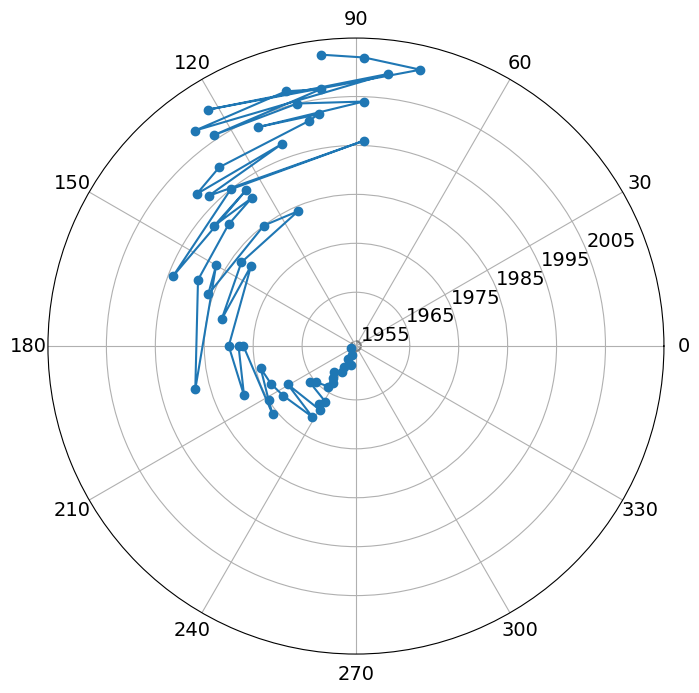

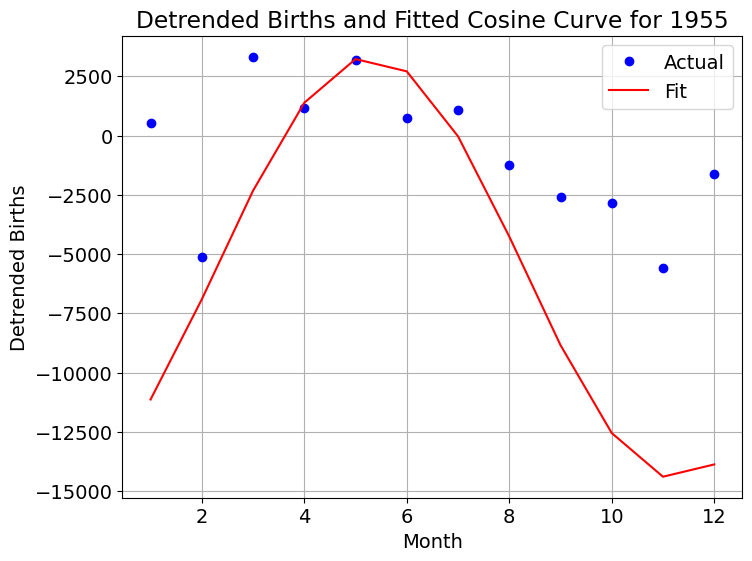

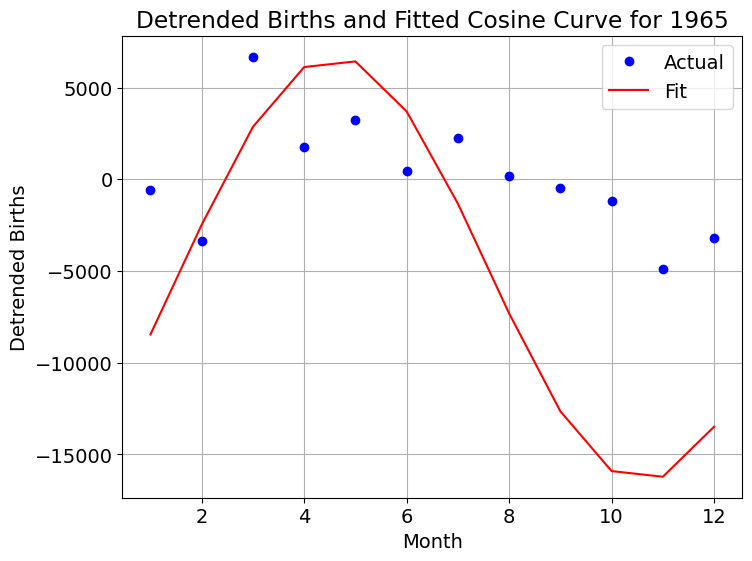

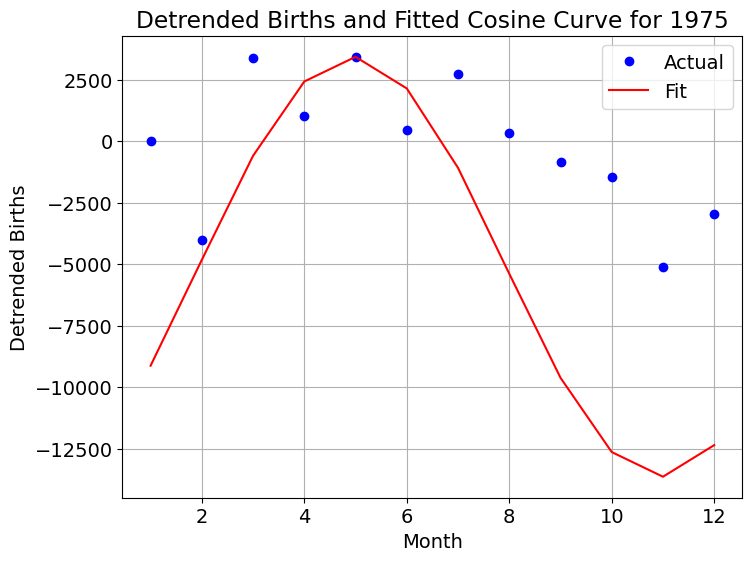

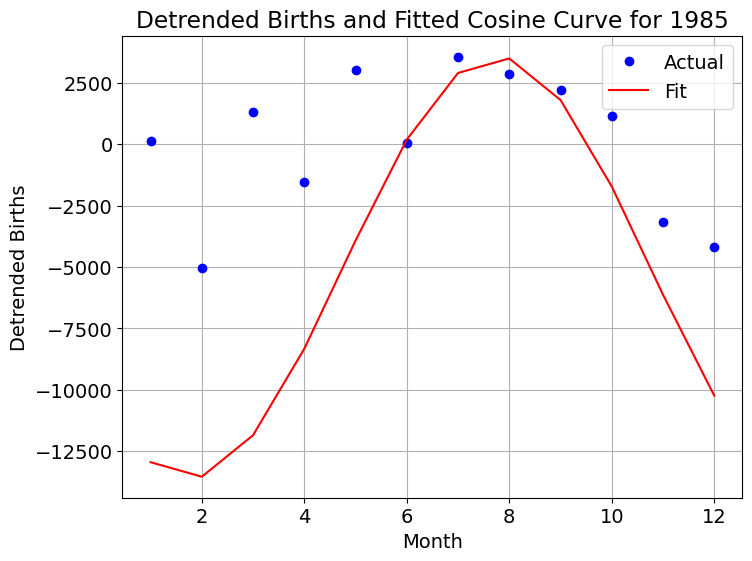

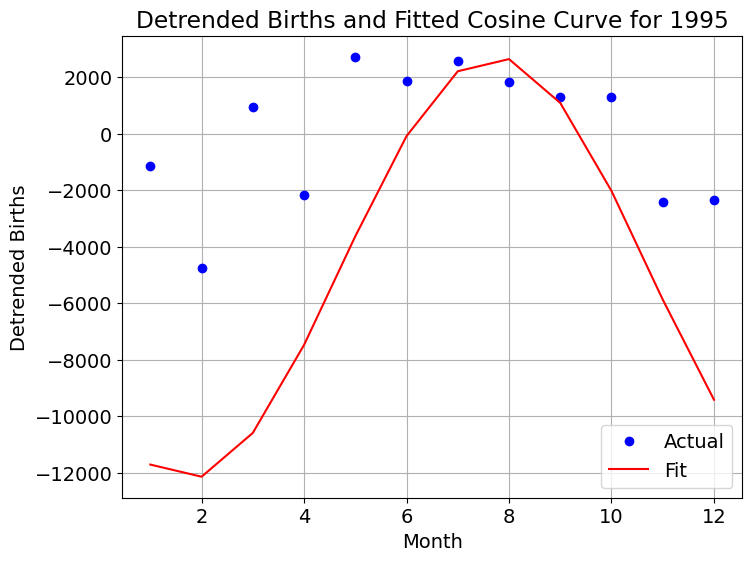

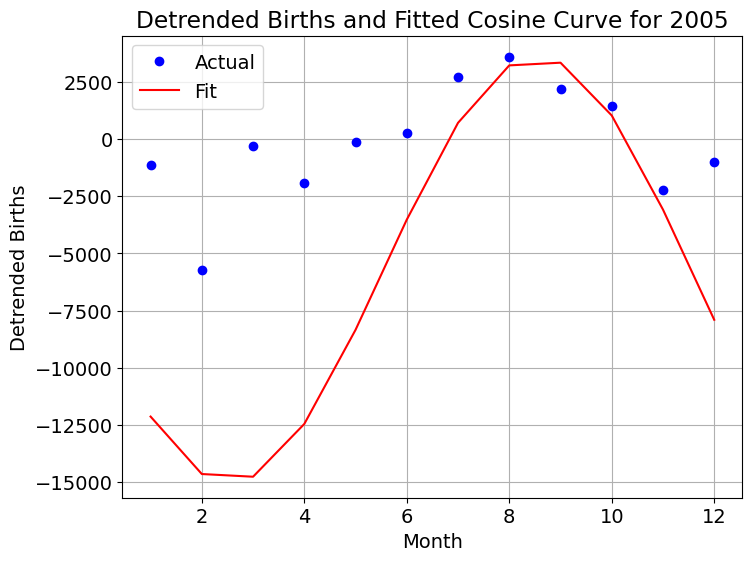

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import statsmodels.api as sm


# Import data from the CSV file named 'data.csv'
data = pd.read_csv('data.csv', names=['Year', 'Month', 'Births', 'PeakConceptionMonth'])

# Capitalize the first letter of each month name
data['Month'] = data['Month'].str.capitalize()

# Combine 'Year' and 'Month' to a 'Date' column
data['Date'] = pd.to_datetime(data['Year'].astype(str) + ' ' + data['Month'], format='%Y %B')

# Detrend the data using a 13-month sliding average for data_1976_2014
x = np.arange(len(data))
y = data['Births'].values

# Calculate the 13-month rolling average
y_detrend = pd.Series(y).rolling(window=13, center=True, min_periods=1).mean().values

# Subtract detrended values from original data and store in a new column
data['DetrendedBirths'] = y - y_detrend

# Group data by year and fit cosine curve for each year
years = data['Year'].unique()

phase_differences = []
for year in years:
    year_data = data[data['Year'] == year]
    x = np.arange(1, 13)
    y = year_data['DetrendedBirths']

    # Define the cosine model function
    def cosine_model(x, amplitude, period, phase, offset):
        return amplitude * np.cos(2 * np.pi * x / period + phase) + offset

    # Set initial parameter values
    initial_params = [np.max(y) - np.min(y), 12, 0, np.min(y)]

    # Fit the data with the cosine model using curve_fit
    popt, pcov = curve_fit(cosine_model, x, y, p0=initial_params, bounds=([0, 11, -np.pi, -np.inf], [np.inf, 13, np.pi, np.inf]), maxfev=100000)
    phase_difference = popt[2]  # Get phase difference in radians

    phase_differences.append(phase_difference)

plt.rcParams.update({'font.size': 14})

# Plot the phase differences
plt.figure(figsize=(8, 8))

# Grey reference circle
plt.polar(np.linspace(0, 2 * np.pi, len(phase_differences) + 1)[:-1], np.ones_like(phase_differences), color='gray', linestyle='--')

# Connecting line in tab:blue
plt.polar(phase_differences, np.arange(1, len(phase_differences) + 1), color='tab:blue', linestyle='-')

# Plot the points
plt.polar(phase_differences, np.arange(1, len(phase_differences) + 1), 'bo', color='tab:blue')

# Grid and labels
plt.thetagrids(range(0, 360, 30), labels=['0', '30', '60', '90', '120', '150', '180', '210', '240', '270', '300', '330'])
plt.rgrids(np.arange(1, len(phase_differences) + 1, 10), labels=[str(year) for year in years if year % 10 == 5])

plt.show()


# Define the cosine model function for convenience
def cosine_model(x, amplitude, period, phase, offset):
    return amplitude * np.cos(2 * np.pi * x / period + phase) + offset

# List of years to generate plots for
plot_years = [1955, 1965, 1975, 1985, 1995, 2005]

for year in plot_years:
    # Get the data and phase difference for the selected year
    year_data = data[data['Year'] == year]
    x = np.arange(1, 13)
    y = year_data['DetrendedBirths']
    phase_difference = phase_differences[years.tolist().index(year)]

    # Use the phase difference to predict the detrended birth rates using the cosine model
    amplitude_estimate = np.max(y) - np.min(y)
    offset_estimate = np.min(y)
    y_fit = cosine_model(x, amplitude_estimate, 12, phase_difference, offset_estimate)

    # Plot the actual and predicted data
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, 'bo', label='Actual')
    plt.plot(x, y_fit, 'r-', label='Fit')
    plt.title(f'Detrended Births and Fitted Cosine Curve for {year}')
    plt.xlabel('Month')
    plt.ylabel('Detrended Births')
    plt.legend()
    plt.grid()
    plt.show()


Figure 2C

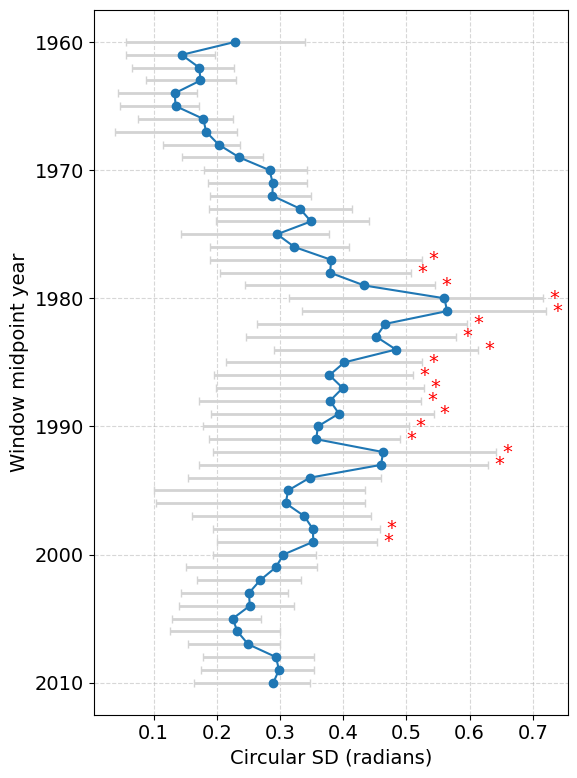

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# define phases for convenience
phases = np.array(phase_differences)


# Circular standard deviation function
def circ_std(angles):
    R = np.abs(np.mean(np.exp(1j * angles)))
    return np.sqrt(-2 * np.log(R))

# Circular confidence interval of the mean (used for proxy)
def circ_confidence_interval(angles, alpha=0.05):
    n = len(angles)
    R = np.abs(np.mean(np.exp(1j * angles)))
    se = np.sqrt(-2 * np.log(R)) / np.sqrt(n)
    z = 1.96  # for 95% CI
    ci = z * se
    mu = np.angle(np.mean(np.exp(1j * angles)))
    return mu, mu - ci, mu + ci

# --- 1. Sliding‐window bootstrap for SD and CI ---
window = 10      # years per window
step = 1         # shift step
n_boot = 1000    # bootstrap samples
rng = np.random.default_rng(0)

mid_years = []
sds       = []
ci_los    = []
ci_his    = []

for start in range(years.min(), years.max() - window + 2, step):
    end = start + window - 1
    mask = (years >= start) & (years <= end)
    ph = phases[mask]
    if len(ph) < window:
        continue

    # observed SD
    sd_obs = circ_std(ph)

    # bootstrap SD distribution
    bootsd = rng.choice(ph, size=(n_boot, len(ph)), replace=True)
    bootsd = np.array([circ_std(row) for row in bootsd])

    # 95% CI for SD
    lo, hi = np.percentile(bootsd, [2.5, 97.5])

    # record
    mid_years.append(start + window // 2)
    sds.append(sd_obs)
    ci_los.append(sd_obs - lo)
    ci_his.append(hi - sd_obs)

mid_years = np.array(mid_years)
sds       = np.array(sds)
ci_los    = np.array(ci_los)
ci_his    = np.array(ci_his)

# --- 2. Baseline bootstrap distribution (1955–1974) ---
baseline_mask = (years >= 1955) & (years <= 1974)
baseline_ph   = phases[baseline_mask]

baseline_bootsd = rng.choice(baseline_ph, size=(n_boot, len(baseline_ph)), replace=True)
baseline_bootsd = np.array([circ_std(row) for row in baseline_bootsd])

# --- 3. Two‐sided p‐values comparing each window SD to baseline ---
pvals = []
for sd_obs in sds:
    prop_higher = np.mean(baseline_bootsd >= sd_obs)
    prop_lower  = np.mean(baseline_bootsd <= sd_obs)
    pval = 2 * min(prop_higher, prop_lower)
    pvals.append(pval)
pvals = np.array(pvals)

# Identify post‐baseline significance
baseline_end = 1974
sig_mask = (mid_years > baseline_end) & (pvals < 0.05)


def circ_std(angles):
    R = np.abs(np.mean(np.exp(1j * angles)))
    return np.sqrt(-2 * np.log(R))

# --- 4. Plot with significance asterisks ---

# (Re-use the bootstrap‐derived mid_years, sds, ci_los, ci_his, and sig_mask arrays from your script)
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(6, 8))

# Horizontal errorbar: x = SD, y = midpoint year
ax.errorbar(
    sds,
    mid_years,
    xerr=[ci_los, ci_his],  # now horizontal errors
    fmt='o-',
    color='tab:blue',
    ecolor='lightgray',
    elinewidth=2,
    capsize=3
)

# Plot significance asterisks to the right of each point
for idx in np.where(sig_mask)[0]:
    y = mid_years[idx]
    x = sds[idx]
    xerr = ci_his[idx]
    # place asterisk just beyond the upper CI
    ax.text(x + xerr + 0.01, y, '*', va='center', ha='left', color='red', fontsize=14)

# Labels & grid
ax.set_ylabel('Window midpoint year')
ax.set_xlabel('Circular SD (radians)')
#ax.set_title(f'{window}-year Sliding Window Variability of Peak Phase')
ax.grid(True, linestyle='--', alpha=0.5)

# Labels & grid
ax.set_ylabel('Window midpoint year')
ax.set_xlabel('Circular SD (radians)')
ax.grid(True, linestyle='--', alpha=0.5)

# Reverse the y-axis direction
ax.invert_yaxis()           # ← add this line

plt.tight_layout()
plt.show()